# Solving Lorenz '96 with Parareal

In the notebook we will use the parareal algorithm to solve the Lorenz 96 (L96) system. L96 is a toy model that emulates a multi-level level dynamical system. Following Thorn et al. 2017 formulation:

\begin{equation}
\frac{\textrm{d}X_k}{\textrm{d}t} = X_{k-1}(X_{k+1} - X_{k-2}) - X_k + F - \frac{hc}{b}\sum_{j=1}^j Y_{j,k}
\label{eqn:l96X} \tag{1}
\end{equation}

\begin{equation}
\frac{\textrm{d}Y_{j,k}}{\textrm{d}t} = -cbY_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - cY_{j,k} + \frac{hc}{b}X_{k} - \frac{he}{d}\sum_{i=1}^I Z_{i,j,k}
\label{eqn:l96Y} \tag{2}
\end{equation}

\begin{equation}
\frac{\textrm{d}Z_{i,j,k}}{\textrm{d}t} = -edZ_{i-1,j,k}(Z_{i+1,j,k} - Z_{i-2,j,k}) - g_ZeZ_{i,j,k} + \frac{he}{d} Y_{j,k}
\label{eqn:l96Z} \tag{3}
\end{equation}

Where X is analgous to large-scale synoptic quantity arranged on a latitude circule. Each of K components in X are coupled to J fast-moving, smaller-scale Y variables that could represent some convective scale quantity. Z is even smaller-scale, faster moving, variables which could be analogous to individual clouds in the real atmosphere. *F* is the large-scale forcing and *h* is the strength of coupling between different spatial scales. Parameters *d* and e represent the magnitude and evolution speed ratios respectively of the the Y and Z variables. $g_Z$ is a damping parameter.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import parareal as para
from itertools import chain, repeat
from importlib import reload
# %matplotlib inline

In [15]:
reload(para)

<module 'parareal' from '/Users/oj244/home/Projects/APinT/APinTA/tutorial/parareal.py'>

In [2]:
# 3 level Lorenz 96 implementation
class Lorenz96_three(object):
    def __init__(self, K=1,J=1,I=1,nlevels=1,h=None,g=None,
            F=None,c=None,b=None,e=None,d=None,
            X0=None,Y0=None,Z0=None):
        """
        Follows 3 level Lorenz 96 formulation in Thornes et al (2016)
        https://doi.org/10.1002/qj.2974
        K : number of X variables
        J : number of Y variables
        I : number of Z variables
        h : coupling constant between X and Y
        g : Z damping parameter
        F : Forcing term
        c : time scale ratio between X and Y
        b : spatial scale ratio between X and Y
        e : time scale ratio between Y and Z
        d : spatial scale ratio between Y and Z
        """
        assert(K is not None), 'Need to set K value'
        assert(F is not None), 'Need to set F value'
        assert(J is not None), 'Need to set J value'
        assert(h is not None), 'Need to set h value'
        assert(F is not None), 'Need to set F value'
        assert(c is not None), 'Need to set c value'
        assert(b is not None), 'Need to set b value'
        assert(K is not None), 'Need to set K value'
        assert(g is not None), 'Need to set g value'
        assert(e is not None), 'Need to set e value'
        assert(d is not None), 'Need to set d value'

        if X0 is not None:
             self._X = X0.copy()
        else:
             #self._X = np.random.normal(loc=0,scale = 1, size=(K,J,I))
             self._X = np.random.normal(loc=0,scale = 1, size=(3,K,J,I))

        self.h = h
        self.g = g
        self.F = F
        self.c = c
        self.b = b
        self.e = e
        self.d = d
        self.out_array = np.zeros((3,K,J,I))

    @property
    def X_level(self):
        """
        get X level array
        """
        return self._X[0,:,0,0]
    
    @property
    def Y_level(self):
        """
        get Y level array
        """
        return self._X[1,:,:,0]
    
    @property
    def Z_level(self):
        """
        get Z level array
        """
        return self._X[2,:]
         
    def rk4_step(self,dt, A):
        """
        A single timestep using RK4
        """
        x,y,z = A[0,:,0,0],A[1,:,:,0],A[2,:]
        x1,y1,z1 = self.l96(x,y,z)  
        x2,y2,z2 = self.l96(x+x1*dt/2.0,
                y + y1*dt/2.0,
                z + z1*dt/2.0)
        x3,y3,z3 = self.l96(x+x2*dt/2.0,
                y + y2*dt/2.0,
                z + z2*dt/2.0)
        x4,y4,z4 = self.l96(x+x3*dt/2.0,
                y + y3*dt/2.0,
                z + z3*dt/2.0)
        x_n = x + dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
        y_n = y + dt*(y1 + 2*y2 + 2*y3 + y4)/6.0
        z_n = z + dt*(z1 + 2*z2 + 2*z3 + z4)/6.0
        self.out_array[0,:,0,0] = x_n
        self.out_array[1,:,:,0] = y_n
        self.out_array[2,:] = z_n
        #return np.stack((x_n, y_n, z_n))
        return self.out_array 
        

    def _l96_three(self, X, Y, Z):
        """
        three level l96
        """
        Y_next,Z_next = 0.,0.  
        X_next = np.roll(X,1)*(np.roll(X,-1) - np.roll(X,2)) - X + self.F
        X_next -= (self.h*self.c/self.b)*Y.sum(axis=1)
        Y_next = -self.c*self.b*np.roll(Y,-1)*(np.roll(Y,-2) - np.roll(Y,1)) - self.c*Y + (self.h*self.c/self.b)*X[:,None]
        Y_next -= (self.h*self.e/self.d)*Z.sum(axis=2)
        Z_next = self.e*self.d*np.roll(Z,1)*(np.roll(Z,-1) - np.roll(Z,2)) - self.g*self.e*Z + (self.h*self.e/self.d)*Y[:,:,None]
        return X_next, Y_next, Z_next
    

    def l96(self, X,Y,Z):
        """
        The L96 model depending on the number of levels
        """
        X_next, Y_next, Z_next = self._l96_three(X,Y,Z) 
         
        return X_next, Y_next, Z_next 



In [3]:
def rk4_step_l96(dt, A, f, **f_kwargs):
    """
    A single timestep using RK4
    """
    out_array = np.zeros(A.shape)
    x,y,z = A[0,:,0,0],A[1,:,:,0],A[2,:]
    x1,y1,z1 = f(x,y,z)  
    x2,y2,z2 = f(x+x1*dt/2.0,
            y + y1*dt/2.0,
            z + z1*dt/2.0)
    x3,y3,z3 = f(x+x2*dt/2.0,
            y + y2*dt/2.0,
            z + z2*dt/2.0)
    x4,y4,z4 = f(x+x3*dt/2.0,
            y + y3*dt/2.0,
            z + z3*dt/2.0)
    x_n = x + dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
    y_n = y + dt*(y1 + 2*y2 + 2*y3 + y4)/6.0
    z_n = z + dt*(z1 + 2*z2 + 2*z3 + z4)/6.0
    out_array[0,:,0,0] = x_n
    out_array[1,:,:,0] = y_n
    out_array[2,:] = z_n
    #return np.stack((x_n, y_n, z_n))
    return out_array 


In [4]:
# Polar plots
def plot_l96_polar(yG_correct, correction):
    """
    Plot X,Y,Z variables
    """
    # (npoints, K_para,K_lorenz,J_lorenz,I_lorenz)
    XG = np.array(yG_correct[1:,:,0,:]) 
    YG = np.array(yG_correct[1:,:,1,:])
    ZG = np.array(yG_correct[1:,:,2,:])

    # (npoints, K_para,K_lorenz,J_lorenz,I_lorenz)
    Xc = np.array(correction[:,:,-1,0,:]) 
    Yc = np.array(correction[:,:,-1,1,:])
    Zc = np.array(correction[:,:,-1,2,:])

    x_r = np.linspace(0,2,XG.shape[-3]) 
    X_theta = np.pi*x_r
    y_r = np.linspace(0,2,len(np.arange(YG.shape[-3]*YG.shape[-2])))
    Y_theta = np.pi*y_r
    z_r = np.linspace(0,2,len(np.arange(ZG.shape[-3]*ZG.shape[-2]*ZG.shape[-1])))
    Z_theta = np.pi*z_r

    for k in range(XG.shape[1]):
        fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection':'polar'},figsize=(12,6)) 
        ax1.plot(X_theta,XG[-1,k,:,0,0], label='X')
        ax1.plot(X_theta,Xc[-1,k,:,0,0], label='X correction')
        ax1.legend(loc='upper left')

        ax2.plot(Y_theta,np.ravel(YG[-1,k,:,:,0]), label='Y')
        ax2.plot(Y_theta,np.ravel(Yc[-1,k,:,:,0]), label='Y Correction')
        ax2.legend(loc='upper left')

        ax3.plot(Z_theta,np.ravel(ZG[-1,k,:,:,:]), label='Z')
        ax3.plot(Z_theta,np.ravel(Zc[-1,k,:,:,:]), label='Z Correction')
        ax3.legend(loc='upper left')
        
        plt.suptitle(f'Iteration {k}')
        plt.savefig(f'l96_polar_iteratin_{k:03}.png')
        plt.show()



In [10]:
def run_l96_parareal():
    """
    Solve L96 system using the parareal algorithm
    """
    a = 0
    b = 10.
    nG = 180
    nF = 14400 
    K = 20
    y0 = [5,-5,20]
    xG = np.linspace(a,b,nG+1)
    deltaG = (b-a)/nG
    xF = np.zeros((nG, int(nF/nG)+1))
    for i in range(nG):
        left,right = xG[i], xG[i+1]
        xF[i,:] = np.linspace(left,right,int(nF/nG)+1) 
     
    deltaF = xF[0,1] - xF[0,0]
    f_kwargs = {"sigma" : 10, "beta" : 8/3, "rho" : 28}
    K_lorenz = 36 
    J_lorenz = 10 
    I_lorenz = 10 
    nlevels = 3
    h, g = 1., 1.
    b, c, e, d = 1., 1., 1., 1.
    F = 10.

    L96 = Lorenz96_three(K=K_lorenz,J=J_lorenz,I=I_lorenz,h=h,g=g,b=b,c=c,e=e,d=d,F=F,nlevels=3)
    # x.shape = (K)
    # y.shape = (K,J)
    # z.shape = (K,J,I)
    x,y,z = L96.X_level, L96.Y_level, L96.Z_level
    print(x.shape, y.shape, z.shape)
    y0 = np.zeros((3,K_lorenz,J_lorenz,I_lorenz))
    y0[0,:,0,0] = x
    y0[1,:,:,0] = y
    y0[2,:] = z
    # y0 = [x,y,z]
    npoints = 1000
    t_start, t_end = 0,10
    dt = (t_end - t_start)/npoints 

    pr = para.Parareal(rk4_step_l96, rk4_step_l96)
    yG_correct, correction = pr.parareal(y0, nG, nF, deltaG, deltaF, K, L96.l96, **f_kwargs)
    plot_l96_polar(yG_correct, correction)
 

(36,) (36, 10) (36, 10, 10)


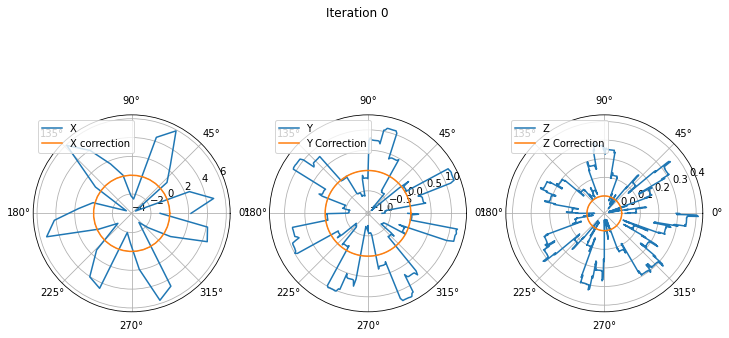

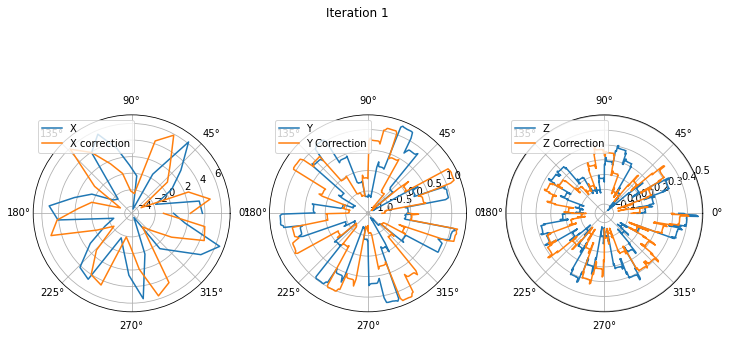

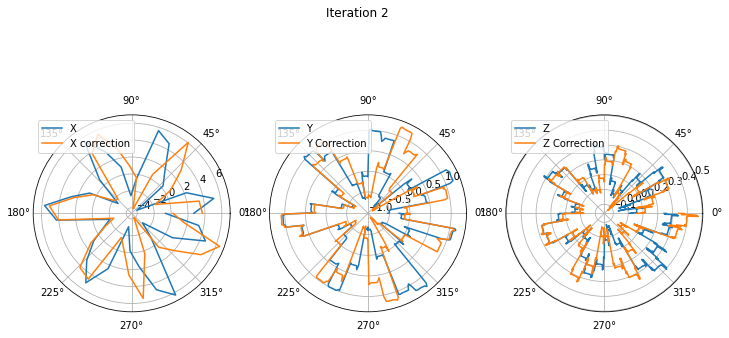

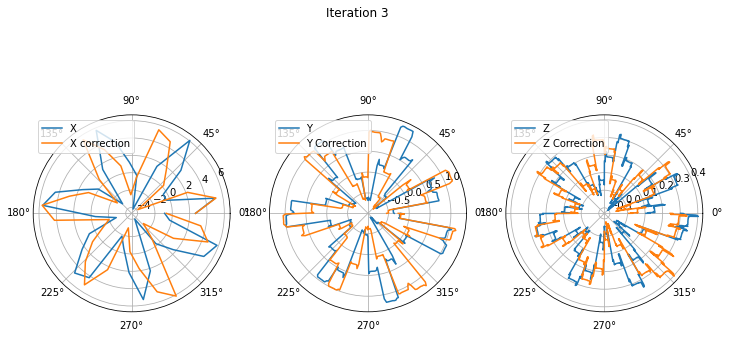

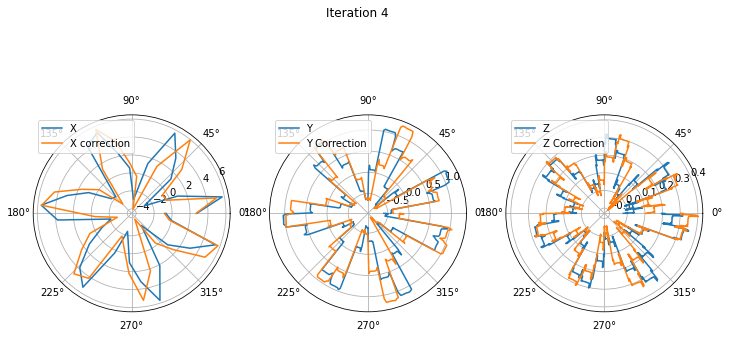

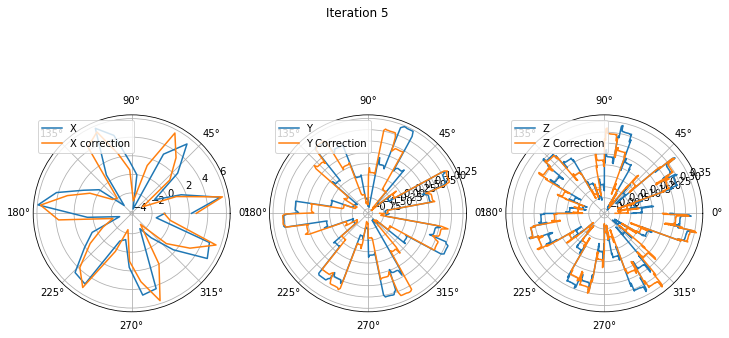

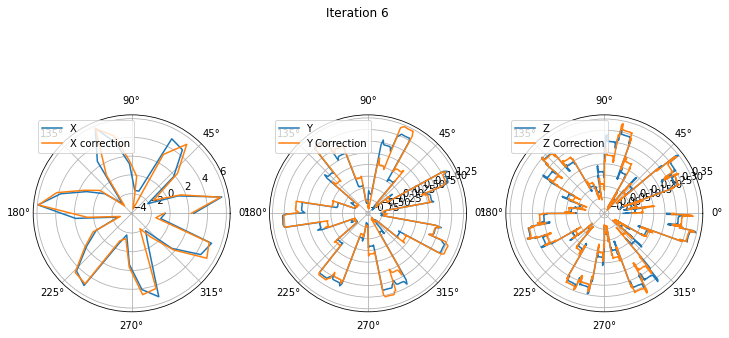

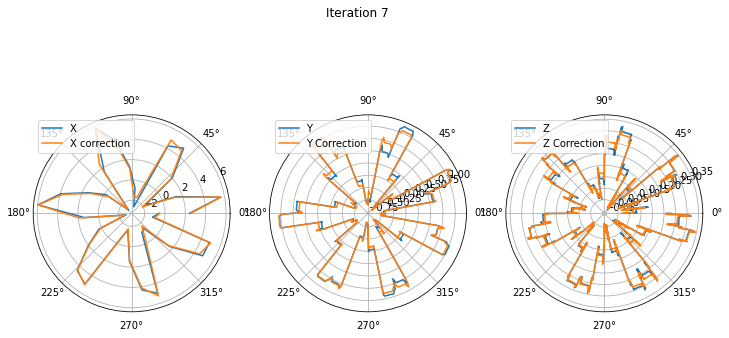

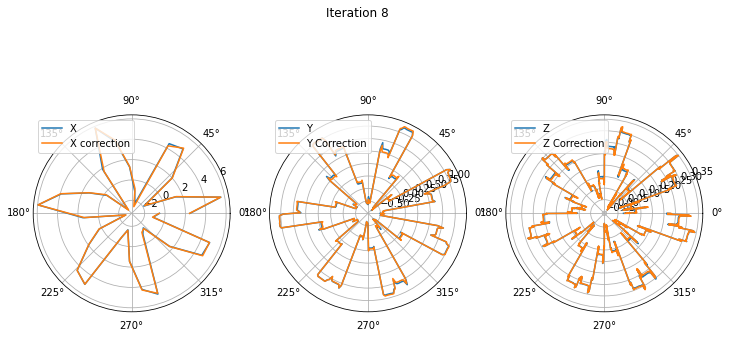

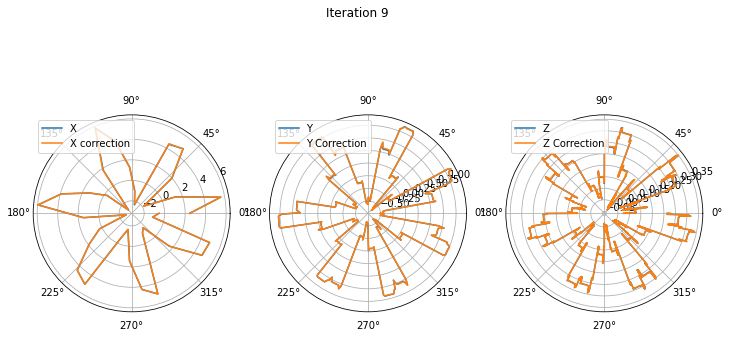

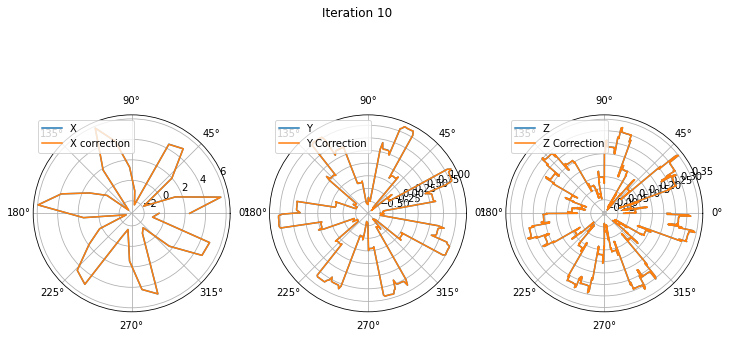

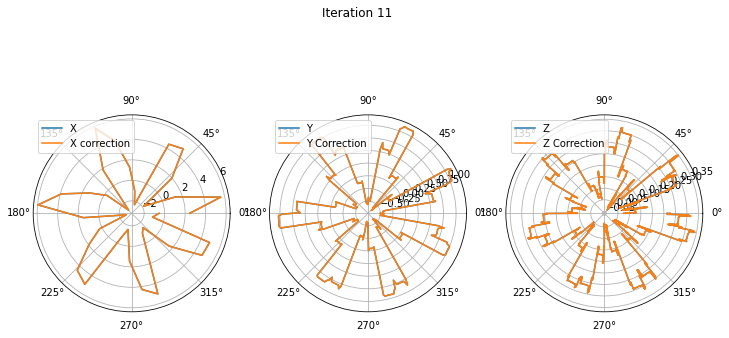

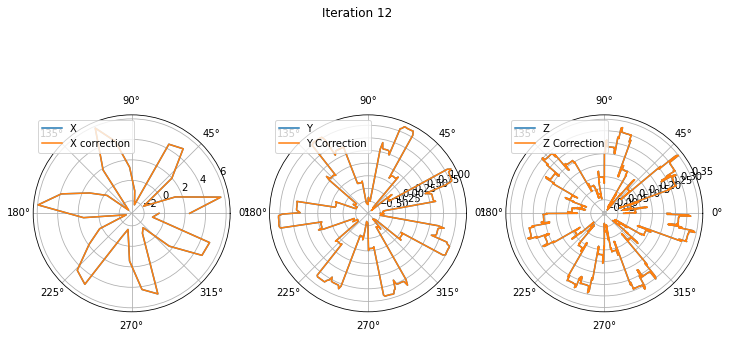

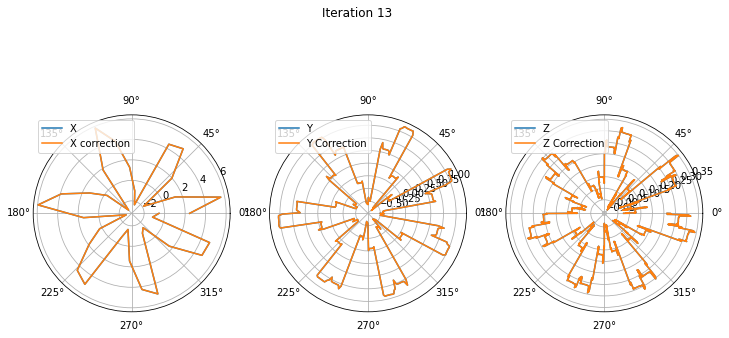

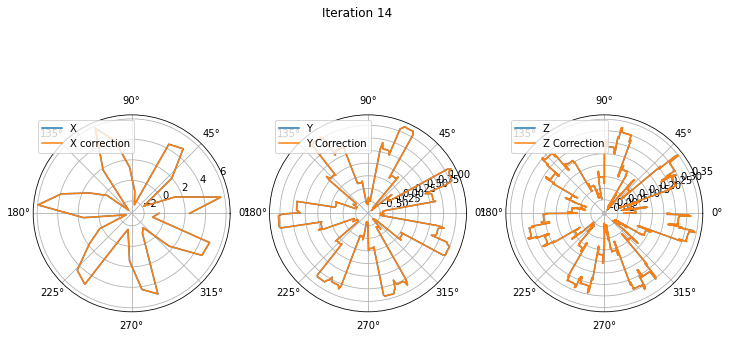

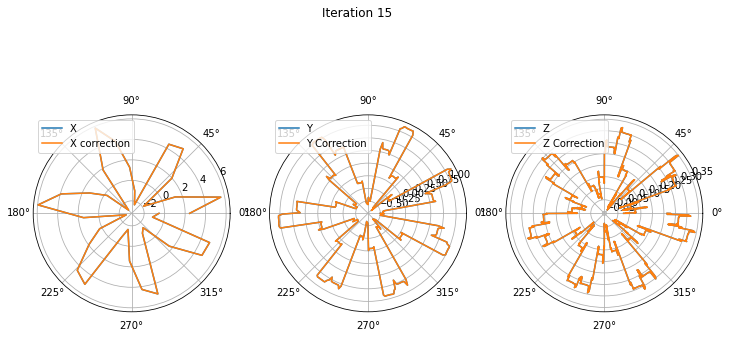

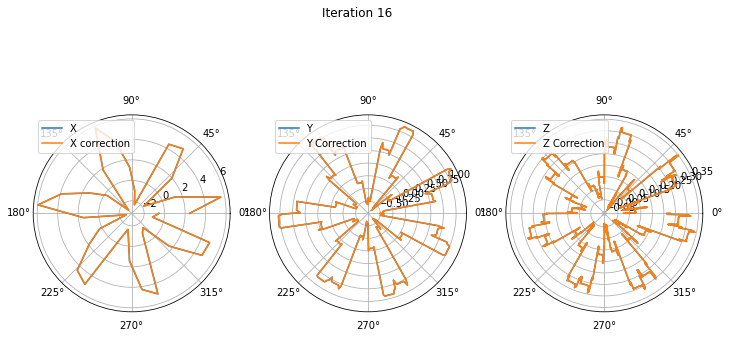

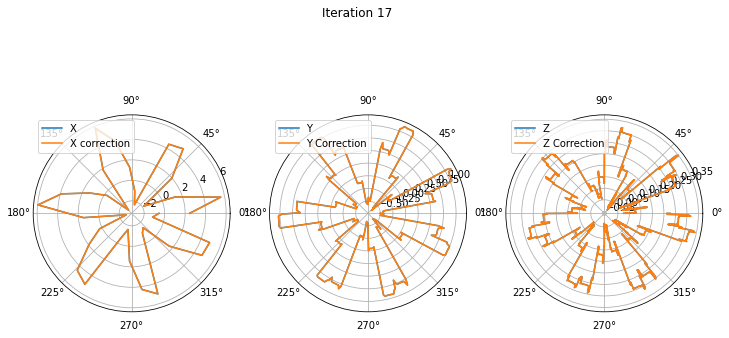

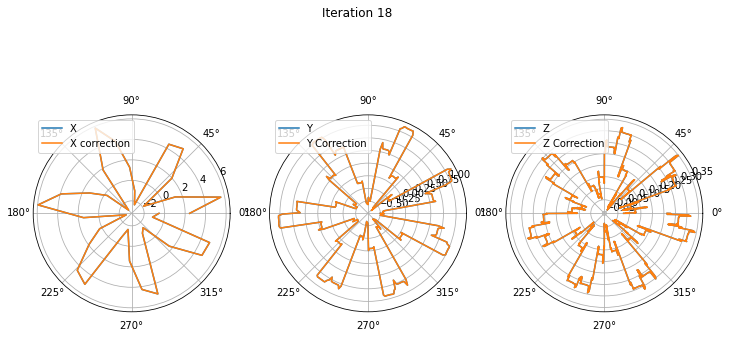

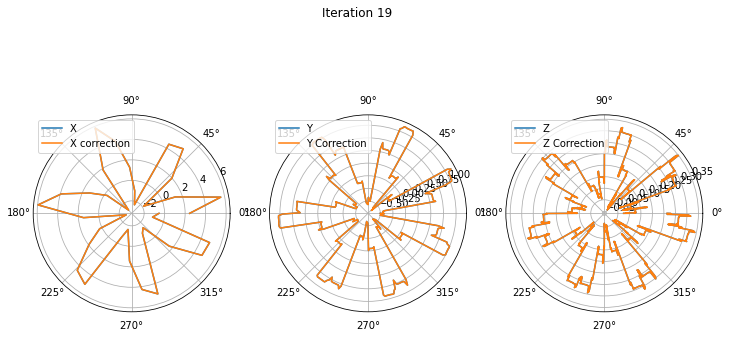

In [16]:
run_l96_parareal()